This notebook exists to mainly find out the best model used for prediction.

In [1]:
import pandas as pd

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SALE DATA

In [2]:
sale_df = pd.read_csv('../data/iProperty_sale_to_be_trained.csv')

sale_df.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = sale_df[col].quantile(0.01)
    q_hi  = sale_df[col].quantile(0.99)
    sale_df = sale_df[(sale_df[col] < q_hi) & (sale_df[col] > q_low)]
    
one_hot = pd.get_dummies(sale_df[['district','state','type','details']])
sale_df = sale_df.join(one_hot).drop(['district','state','type','details'], axis=1)

sale_x = sale_df.drop(['price'],axis=1)
sale_y = sale_df['price']

sale_x_train, sale_x_test, sale_y_train, sale_y_test = train_test_split(sale_x, sale_y, test_size=0.2)

RENT DATA

In [3]:
rent_df = pd.read_csv('../data/iProperty_rent_to_be_trained.csv')

rent_df.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = rent_df[col].quantile(0.01)
    q_hi  = rent_df[col].quantile(0.99)
    rent_df = rent_df[(rent_df[col] < q_hi) & (rent_df[col] > q_low)]
    
one_hot = pd.get_dummies(rent_df[['district','state','type','details']])
rent_df = rent_df.join(one_hot).drop(['district','state','type','details'], axis=1)

rent_x = rent_df.drop(['price'],axis=1)
rent_y = rent_df['price']

rent_x_train, rent_x_test, rent_y_train, rent_y_test = train_test_split(rent_x, rent_y, test_size=0.2)

### XGB Regressor

In [4]:
xg_hyperparameters = {
    'n_estimators': [300],
    'max_depth': [5],
    'eta': [0.2],
    'subsample': [0.8],
    'colsample_bytree' : [0.9],
    'alpha': [0.0,0.1,0.2],
    'lambda': [1.0,1.1,1.2]
}

In [5]:
xg_score = {
    'score':['R2','RMSE','MAE','MAPE']
}

on SALE DATA

In [6]:
# model_s = GridSearchCV(estimator=XGBRegressor(), param_grid=xg_hyperparameters, cv=3, n_jobs=-1, verbose=4)
# model_s.fit(sale_x_train, sale_y_train)

# xgs_best_params = model_s.best_params_
# display(xgs_best_params)

# pd.DataFrame.from_dict(model_s.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

In [7]:
xgs_best_params = {
    'alpha': 0.2,
    'colsample_bytree': 0.9,
    'eta': 0.2,
    'lambda': 1.0,
    'max_depth': 5,
    'n_estimators': 300,
    'subsample': 0.8
}

In [8]:
key = 'SALE'

xgs = XGBRegressor()
xgs.set_params(**xgs_best_params)
xgs.fit(sale_x_train,sale_y_train)
sale_y_pred = xgs.predict(sale_x_test)

xg_score[key] = []
xg_score[key].append(r2_score(sale_y_test,sale_y_pred))
xg_score[key].append(mean_squared_error(sale_y_test,sale_y_pred, squared=False))
xg_score[key].append(mean_absolute_error(sale_y_test,sale_y_pred))
xg_score[key].append(mean_absolute_percentage_error(sale_y_test,sale_y_pred))

xg_score

{'score': ['R2', 'RMSE', 'MAE', 'MAPE'],
 'SALE': [0.7958840974619865,
  468227.3531339466,
  253888.48664020287,
  0.2646105747647502]}

on RENT DATA

In [9]:
# model_r = GridSearchCV(estimator=XGBRegressor(), param_grid=xg_hyperparameters, cv=3, n_jobs=-1, verbose=4)
# model_r.fit(sale_x_train, sale_y_train)

# xgr_best_params = model_r.best_params_
# display(xgr_best_params)

# pd.DataFrame.from_dict(model_r.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

In [10]:
xgr_best_params = {
    'alpha': 0.2,
    'colsample_bytree': 0.9,
    'eta': 0.2,
    'lambda': 1.0,
    'max_depth': 5,
    'n_estimators': 300,
    'subsample': 0.8
}

In [11]:
key = 'RENT'

xgr = XGBRegressor()
xgr.set_params(**xgr_best_params)
xgr.fit(rent_x_train,rent_y_train)
rent_y_pred = xgr.predict(rent_x_test)

xg_score[key] = []
xg_score[key].append(r2_score(rent_y_test,rent_y_pred))
xg_score[key].append(mean_squared_error(rent_y_test,rent_y_pred, squared=False))
xg_score[key].append(mean_absolute_error(rent_y_test,rent_y_pred))
xg_score[key].append(mean_absolute_percentage_error(rent_y_test,rent_y_pred))

xg_score

{'score': ['R2', 'RMSE', 'MAE', 'MAPE'],
 'SALE': [0.7958840974619865,
  468227.3531339466,
  253888.48664020287,
  0.2646105747647502],
 'RENT': [0.7758194789270214,
  914.1527182953237,
  549.049054206859,
  0.23024466674764965]}

In [12]:
xg_df = pd.DataFrame(xg_score).T
xg_df.columns = xg_df.iloc[0]
xg_df = xg_df[1:]
xg_df = xg_df.reset_index()
xg_df.rename(columns={'index':'data'}, inplace=True)
xg_df

score,data,R2,RMSE,MAE,MAPE
0,SALE,0.795884,468227.353134,253888.48664,0.264611
1,RENT,0.775819,914.152718,549.049054,0.230245


(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

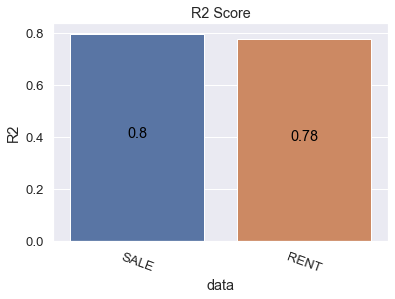

In [17]:
metric = 'R2'
p = sns.barplot(data=xg_df, x='data', y='R2')
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i],2)),
           fontdict=dict(color='black'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

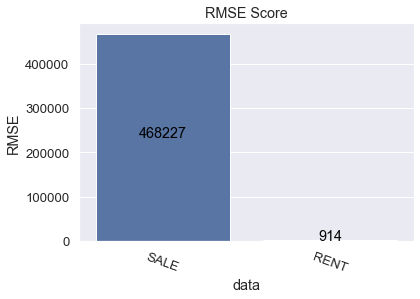

In [18]:
metric = 'RMSE'
p = sns.barplot(data=xg_df, x='data', y=metric)
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i])),
           fontdict=dict(color='black'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

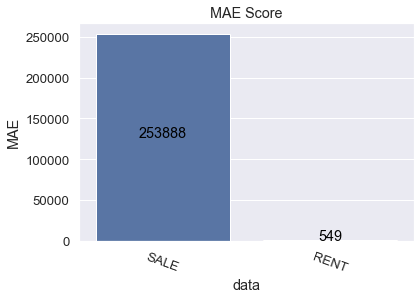

In [19]:
metric = 'MAE'
p = sns.barplot(data=xg_df, x='data', y=metric)
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i])),
           fontdict=dict(color='black'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

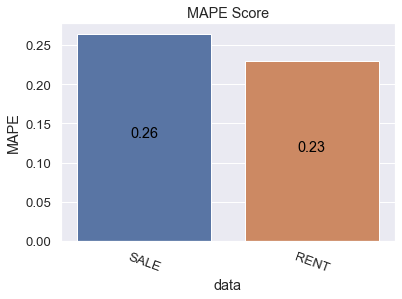

In [20]:
metric = 'MAPE'
p = sns.barplot(data=xg_df, x='data', y=metric)
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i],2)),
           fontdict=dict(color='black'),
          horizontalalignment='center')
plt.xticks(rotation=-20)